# Importing necessary libraries

In [ ]:
from torch.nn.modules import dropout
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torch
from torch import nn
import numpy as np

# Downloading Data

In [ ]:
# Define the data transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


100%|██████████| 170498071/170498071 [00:03<00:00, 46015995.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Define model

In [ ]:
# Define the model
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, num_convs):
        super(Block, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for i in range(num_convs)])
        #self.bns = nn.ModuleList([nn.BatchNorm2d(out_channels) for i in range(num_convs)])
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(p=0.2)
        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(in_channels, num_convs ),
            nn.ReLU(inplace=True)
        )
 
    def forward(self, x):
        a = self.mlp(x)
        out = 0
        for idx, conv in enumerate(self.convs):
            y = conv(x)
            y = self.bn(y)
            y = nn.functional.relu(y)
            #y = self.dropout(y)
            out += a[:, idx].view(x.size(0), -1, 1, 1) * y
        out += self.conv1x1(x)
        out = nn.functional.relu(out)
        return out

class Classifier(nn.Module):
    def __init__(self, num_blocks, num_filters, num_classes, num_convs):
        super(Classifier, self).__init__()
        self.blocks = nn.ModuleList([Block(3 if i == 0 else num_filters, num_filters, num_convs) for i in range(num_blocks)])
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(num_filters, num_classes)
        
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Define optimmiser and loss function 


In [ ]:
# Define the model, optimizer, and loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Classifier(num_blocks=3, num_filters=64, num_classes=10, num_convs=3).to(device)
criterion = nn.CrossEntropyLoss()


# Define the optimizer and learning rate scheduler
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)


# Training 

Epoch [1] trainng loss: 1.750, training accuracy: 34 %
Epoch [1] validation accuracy: 46 %
Epoch [2] trainng loss: 1.365, training accuracy: 50 %
Epoch [2] validation accuracy: 51 %
Epoch [3] trainng loss: 1.217, training accuracy: 56 %
Epoch [3] validation accuracy: 55 %
Epoch [4] trainng loss: 1.128, training accuracy: 59 %
Epoch [4] validation accuracy: 57 %
Epoch [5] trainng loss: 1.051, training accuracy: 62 %
Epoch [5] validation accuracy: 60 %
Epoch [6] trainng loss: 0.994, training accuracy: 64 %
Epoch [6] validation accuracy: 62 %
Epoch [7] trainng loss: 0.949, training accuracy: 66 %
Epoch [7] validation accuracy: 65 %
Epoch [8] trainng loss: 0.907, training accuracy: 67 %
Epoch [8] validation accuracy: 65 %
Epoch [9] trainng loss: 0.870, training accuracy: 69 %
Epoch [9] validation accuracy: 65 %
Epoch [10] trainng loss: 0.836, training accuracy: 70 %
Epoch [10] validation accuracy: 68 %
Epoch [11] trainng loss: 0.813, training accuracy: 71 %
Epoch [11] validation accuracy: 

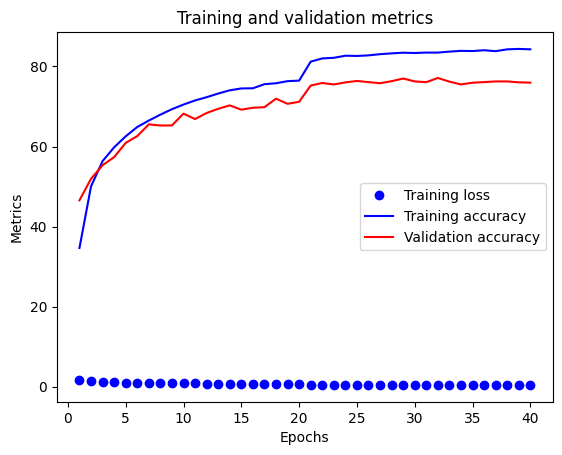

In [ ]:
import matplotlib.pyplot as plt

# Train the network
num_epochs = 40
train_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        #if i % 100 == 99:    # print every 100 mini-batches

    # Decay Learning rate after epoch
    lr_scheduler.step()
    
    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print('Epoch [%d] trainng loss: %.3f, training accuracy: %d %%' %(epoch + 1, train_loss, train_acc))
    running_loss = 0.0

    # Test the network on the validation data
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_acc = 100 * correct_val / total_val
    val_accs.append(val_acc)
    print('Epoch [%d] validation accuracy: %d %%' % (epoch + 1, val_acc))

print('Finished Training')

# Plot training and validation metrics
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, train_accs, 'b', label='Training accuracy')
plt.plot(epochs, val_accs, 'r', label='Validation accuracy')
plt.title('Training and validation metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


## Hyper parameters used 

Hyperparameters used:


Epochs: 40


Batch size: 128


Learning rate: 0.01


Weight decay: 5e-4.


Optimizer: SGD


Loss: Cross entropy loss



Number of blocks: 2
